# Explorer Baseball Reference Data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import ml_insights as mli
import copy

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

Open all_batters.csv

In [2]:
batters_df = pd.read_csv('all_batters.csv')

Generate Historical Salary Data in order to account for salary inflation

In [3]:
mlb_salary_data = [[1967, 6000, 19000], [1970, 12000, 29303], [1975, 16000, 44676],
 [1980, 30000, 143676], [1985, 60000, 371157], [1990, 100000, 597537],
 [1995, 109000, 1110766], [2000, 200000, 1895630], [2005, 316000, 2476589],
 [2010, 400000, 3014572], [2015, 507500, 3952252]]

salary_df = pd.DataFrame(mlb_salary_data,columns=['Year','min_salary','mean_salary'])
dummy = pd.DataFrame(np.arange(1967,2018),columns=['Year'])
salary_df = salary_df.merge(dummy,how = 'outer').sort_values('Year').set_index('Year')
salary_df = salary_df.interpolate().reset_index()

Define some "helper functions"



In [4]:
# Determine Primary Position and number of positions played
def add_position_cols(df):
    
    new_df = df
    new_df['pos_count'] = df['Pos'].str.replace('[*/]', '').apply(str).apply(len)
    new_df['pos_primary'] = df['Pos'].str.replace('[*/]', '').apply(str).str[0]

    position_names = ['1','2','3','4','5','6','7','8','D']
    for p_name in position_names:
        new_df['Pos_'+ p_name] = df['Pos'].str.contains(p_name)

    new_df['pos_difficulty'] = new_df['pos_primary'] 
    
    #Map Positions by difficulty 0 being, easiest
    # Unlike wikipedia, I think that CF is harder than 2B
    pos_dict = {'D':0, '3':1, '7':2,'9':3,'5':4, '4':5,'8':6,'6':7,'2':8,'1':9,'n':np.nan}
    new_df['pos_difficulty'].replace(pos_dict, inplace=True)
    new_df['pos_difficulty'] = pd.to_numeric(new_df['pos_difficulty'])
        
    return new_df


def add_season_number(df):
    first_year = pd.DataFrame()
    first_year['First_Year'] = df.groupby(['player_id']).min()['Year']
    first_year = first_year.reset_index()
    df = df.merge(first_year, how = 'outer')
    
    df['season_number'] = df['Year'] - df['First_Year'] + 1
    #df = df.drop('First_Year',axis = 1)
    return df

def add_singles(df):
    df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']
    return df

# Separate major and minor leagues stats into separate data frames
def separate_majors_minors(df):
    
    # Groupby should give only total year's stats
    maj_df = df.loc[df['Lg'].isin(['AL','NL','MLB'])].groupby(['player_id','Year']).first()
    maj_df = maj_df.reset_index()
    min_df = df.loc[-df['Lg'].isin(['AL','NL','MLB'])]
    return maj_df, min_df

def make_career_stats(df):
    
    counting_stats = ['G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
       'CS', 'BB', 'SO','TB', 'GDP', 'HBP','SH', 'SF', 'IBB','Salary']
    
    # Will need this later
    df['weighted_OPS+'] = df['OPS+']*df['PA']
    
    # Make groupby object to only do aggregation once
    grouped_obj = df.groupby('player_id')
    df_grouped = grouped_obj.sum()[counting_stats]
    
    
    # Service Time is Cumulative but already calculated for me
    df_grouped['SrvTm'] = grouped_obj.max()['SrvTm']
    
    if 'normalized_salary' in df.columns:
        df_grouped['normalized_salary'] = grouped_obj.sum()['normalized_salary']
    
    ### Generate non "counting stats" ###
    
    ## Batting Average = Number of Hits (divided by) Number of At Bats
    df_grouped['BA'] = df_grouped['H']/df_grouped['AB']
    
    ## On Base Percentage
    # (Hits + Walks + Hit-By-Pitch) divided by (At Bats + Walks+ Hit-By-Pitch + Sac Flys)
    df_grouped['OBP'] = (df_grouped['H'] + df_grouped['BB'] + df_grouped['HBP']) \
        / (df_grouped['AB'] + df_grouped['BB'] + df_grouped['HBP']+df_grouped['SF']) 
        
    ## Slugging Percentage
    # Number of (Singles + [2 x Doubles] +[ 3 x Triples] + [4 x Home Runs]) divided by At Bats
    
    # Need to calculate singles first
    df_grouped['1B'] = df_grouped['H'] - df_grouped['2B'] - df_grouped['3B'] - df_grouped['HR']
    
    df_grouped['SLG'] = (df_grouped['1B'] + 2*df_grouped['2B'] 
                         + 3*df_grouped['3B'] + 4*df_grouped['HR']) / df_grouped['AB']
    
    # On Base Plus Slugging 
    df_grouped['OPS'] = df_grouped['OBP'] + df_grouped['SLG']
    
    # OPS+ (Weighted Average)
    df_grouped['OPS+'] = grouped_obj.sum()['weighted_OPS+']/grouped_obj.sum()['PA']
    
    df_grouped['BB_rate'] = df_grouped['BB']/df_grouped['PA']
    df_grouped['SO_rate'] = df_grouped['SO']/df_grouped['PA']
    df_grouped['HR_rate'] = df_grouped['HR']/df_grouped['PA']
    
    
    return df_grouped


__Clean up the data a bit__

Use Salary Data to create era adjusted salary values.

Baseball salaries have inflated much faster than regular salaries

In [5]:
batters_df = pd.merge(left = batters_df,right = salary_df, on = 'Year' )
batters_df['normalized_salary'] = batters_df['Salary']/batters_df['mean_salary']
#batters_df = batters_df.drop(['mean_salary','min_salary'], 1)

Add other useful columns

In [6]:
batters_df = add_position_cols(batters_df)
batters_df = add_singles(batters_df)

# Remove Pre 2000 data to prevent biasing those years to only have players with long careers
min_year = 1990
max_year = 2016
bad_year = 1994 #Strike year, not full season

__Split data into majors and minors__

In [7]:
majors_df, minors_df = separate_majors_minors(batters_df)

majors_df = add_season_number(majors_df)
majors_df = majors_df.loc[majors_df['Year'] >= min_year]
majors_df = majors_df.loc[majors_df['Year'] <= max_year]
majors_df = majors_df.loc[majors_df['Year'] != bad_year]

# Remove Player Seasons with salary data
majors_df = majors_df.dropna(axis = 0, subset=['normalized_salary'])


#### Aggregate Careers

Majors

Exclued players who started in the major leagues after 2010, as they will not have had a chance to reach free agency.

In [8]:
majors_got_paid = majors_df[majors_df['First_Year']<2010].groupby(['player_id','normalized_salary']).max().reset_index()

Minors

In [9]:
minors_df['Age'] = minors_df.loc[minors_df['Age'] < 26] # Get Rid of non Prospects/ rehab
minors_career_df = make_career_stats(minors_df)
minors_career_df = minors_career_df.drop(['Salary','normalized_salary'], 1)
minors_career_df = minors_career_df.reset_index()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Join minors salary with maximum major league salary
Used for predicting peak salary off of minor league stats

In [10]:
majors_got_paid_max = majors_got_paid.groupby(['player_id'])['normalized_salary'].max()
majors_got_paid_max = pd.DataFrame(majors_got_paid_max).reset_index()

minors_career_df = minors_career_df.merge(majors_got_paid_max, how = 'left')
minors_career_df = minors_career_df.dropna(axis = 0, subset=['normalized_salary'])


## Start by investigating the Majors data


Plot the Data

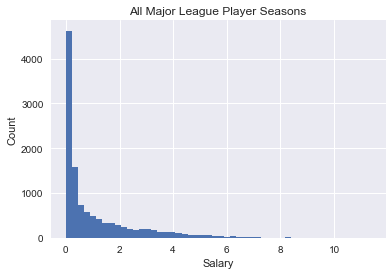

In [11]:
plt.hist(majors_df['normalized_salary'].dropna(how= 'any'),bins = 50);
plt.title('All Major League Player Seasons');
plt.xlabel('Salary');
plt.ylabel('Count');

Very Simple Model

AB = "At Bats" which is a measure of playing time

"OPS+" is a catch all statistic which measures hitting ability relative to peers.

In [12]:
majors_df_reduced1 = majors_df[['Age','AB','OPS+','normalized_salary']]

majors_df_reduced1 = majors_df_reduced1[majors_df_reduced1['AB'] >= 200]
majors_df_reduced1.dropna(how = 'any', inplace = True)


X_all1 = majors_df_reduced1.iloc[:, majors_df_reduced1.columns != 'normalized_salary']
y_all1 = majors_df_reduced1['normalized_salary']

Fit Linear Model

In [13]:
lr_model1 = LinearRegression()

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_all1, y_all1, test_size=0.3,random_state=31)
lr_model1.fit(X_train1, y_train1)

X_test1

,Age,AB,OPS+
17280,28.0,222.0,96.0
13446,26.0,487.0,115.0
2488,22.0,545.0,88.0
2506,27.0,548.0,178.0
7542,28.0,488.0,100.0
3219,32.0,599.0,109.0
9159,28.0,565.0,120.0
13142,25.0,259.0,101.0
3545,21.0,475.0,82.0
13578,27.0,379.0,91.0


In [14]:
predicted_normalized_salaries1 = lr_model1.predict(X_test1)
print(lr_model1.score(X_test1,y_test1))
print(np.sqrt(np.mean((predicted_normalized_salaries1 - y_test1)**2)))

0.345154879958
1.30995345699


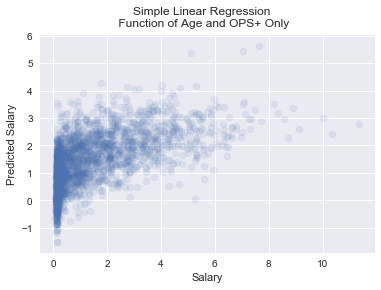

In [15]:
plt.scatter(y_test1,predicted_normalized_salaries1,alpha = 0.1)

plt.ylabel('Predicted Salary')
plt.xlabel('Salary')
plt.suptitle('Simple Linear Regression\n Function of Age and OPS+ Only')
plt.show()

__Lets Look at the Relationships on the full data set__

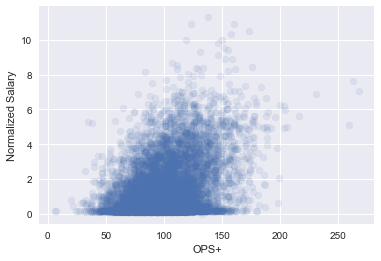

In [16]:
plt.scatter(majors_df_reduced1['OPS+'],majors_df_reduced1['normalized_salary'],alpha = 0.1)
plt.xlabel('OPS+')
plt.ylabel('Normalized Salary')
plt.show()

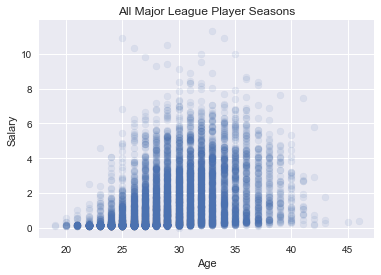

In [17]:
plt.scatter(majors_df_reduced1['Age'],majors_df_reduced1['normalized_salary'],alpha=0.1)
plt.title('All Major League Player Seasons');
plt.xlabel('Age');
plt.ylabel('Salary');

OPS: OBP + SLG 

Catch all stat, but not relative to peers

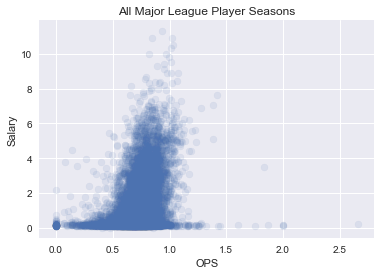

In [18]:
plt.scatter(majors_df['OPS'],majors_df['normalized_salary'],alpha = 0.1);
plt.title('All Major League Player Seasons');
plt.xlabel('OPS');
plt.ylabel('Salary');

Test to make sure my baseball inflation adjuster is working ok

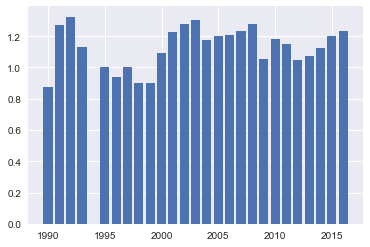

In [19]:
yearly_df = majors_df.groupby('Year').mean()
plt.bar(yearly_df.index, yearly_df['normalized_salary'])
plt.show()

In [20]:
len(majors_df)

11637

## Playing With LASSO

Use only counting stats

This is basically the exact opposite of using OPS+ (which is an aggregated statistic)

In [21]:
#keep_cols = ['season_number', 'AB', 'R', '1B', '2B', '3B', 'HR', 'RBI', 'SB', \
#             'CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','pos_difficulty','normalized_salary']

# keep_cols = ['season_number', 'AB', 'R', 'BA', 'H','SLG', 'OPS', 'HR', 'RBI', 'SB', \
#              'BB', 'SO', 'IBB', 'pos_difficulty', 'normalized_salary']

keep_cols = ['season_number', 'AB', 'R','1B', '2B', '3B', 'HR', 'RBI', 'SB', \
             'SLG','OPS','CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','normalized_salary']
             #'Pos_2', 'Pos_3', 'Pos_4','Pos_5','Pos_6','Pos_7','Pos_8','Pos_D']


# keep_cols = ['season_number', 'AB', 'R','1B', '2B', '3B', 'HR', 'RBI', 'SB', \
#              'BB', 'SO', 'HBP', 'IBB','normalized_salary',\
#             'Pos_2', 'Pos_3', 'Pos_4','Pos_5','Pos_6','Pos_7','Pos_8','Pos_D']

# keep_cols = ['season_number', 'AB', 'R','1B', '2B', '3B', 'HR', 'RBI', 'SB', \
#        'CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','normalized_salary',\
#        'Pos_2', 'Pos_3', 'Pos_4','Pos_5','Pos_6','Pos_7','Pos_8','Pos_D',\
#        'HR_rate','BB_rate', 'SO_rate']

# keep_cols = ['Age', 'AB', 'R','1B', '2B', '3B', 'HR', 'RBI', 'SB', \
#        'CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','normalized_salary',\
#         'Pos_2', 'Pos_3', 'Pos_4','Pos_5','Pos_6','Pos_7','Pos_8','Pos_D']


# keep_cols = ['season_number', 'AB', 'R', 'H','SLG','OPS', 'HR', 'RBI', 'SB', \
#        'CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','normalized_salary']

# Try and then try adding postions


# Filtering out people making close to the minimum
# majors_df_reduced2 = majors_df[(majors_df['Salary'] >= 1.5*majors_df['min_salary']) 
#               & (majors_df['AB']>200)][keep_cols].dropna(axis=0,how = 'any')
majors_df_reduced2 = majors_df[keep_cols].dropna(axis=0,how = 'any')
majors_df_reduced2 = majors_df_reduced2.loc[(majors_df_reduced2['AB']>200)]

#majors_df_reduced2 = shuffle(majors_df_reduced2)

# majors_df_reduced2 = majors_df.loc[(majors_df['AB']>300) 
#                                              & (majors_df['season_number']> 6)][keep_cols].dropna(axis=0,how = 'any')


X_all2 = majors_df_reduced2.iloc[:, majors_df_reduced2.columns != 'normalized_salary']
y_all2 = majors_df_reduced2['normalized_salary']

#X_train2, X_test2, y_train2, y_test2 = train_test_split(X_all2, y_all2, test_size=0.3)

Avoid Shuffling data. Ordering alphabetically. This prevents leakage of players from training set to test set.

However, this means that the same player may appear in either the training set, or test set multiple times. I think this is okay, because as players age they will have different skill sets

In [22]:

split_ind = int(np.shape(X_all2)[0]*.2)
X_train2 = X_all2.iloc[:split_ind,:]
X_test2 = X_all2.iloc[split_ind:,:]
y_train2 = y_all2[:split_ind]
y_test2 = y_all2[split_ind:]

In [23]:
std = StandardScaler()
#std.fit(X_train.values.astype(float))
std.fit(X_train2)

X_tr2 = std.transform(X_train2)
X_te2 = std.transform(X_test2)
lr_model2 = Lasso(alpha = .1)
lr_model2.fit(X_tr2,y_train2)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [24]:
len(y_all2)

7819

In [25]:
list(zip(X_train2.columns,lr_model2.coef_))

[('season_number', 0.63980647713475824),
 ('AB', 0.0),
 ('R', 0.075845899311631437),
 ('1B', 0.0),
 ('2B', 0.0),
 ('3B', -0.0),
 ('HR', 0.073532114576287846),
 ('RBI', 0.22320628385634442),
 ('SB', 0.0),
 ('SLG', 0.0),
 ('OPS', 0.0),
 ('CS', 0.0),
 ('BB', 0.20680924103202714),
 ('SO', -0.0),
 ('GDP', 0.01209065407606655),
 ('HBP', 0.0),
 ('IBB', 0.19736503422550006)]

In [26]:
test_set_pred2 = lr_model2.predict(X_te2)
print(lr_model2.score(X_te2,y_test2))
print(np.sqrt(np.mean((test_set_pred2 - y_test2)**2)))

0.443787246279
1.2133143053


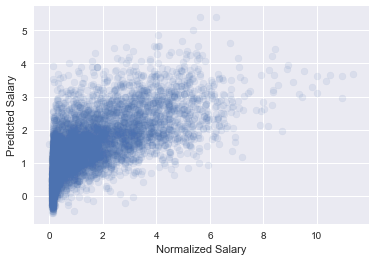

In [27]:
plt.scatter(y_test2,test_set_pred2,alpha = 0.1)
plt.xlabel('Normalized Salary')
plt.ylabel('Predicted Salary')
plt.show()

## Lets Try Lasso CSV

In [28]:
alphavec = 10**np.linspace(-3,2,100)
#alphMavec

# Can use the same slicing of the data as before
lr_model3 = LassoCV(alphas = alphavec, cv=5)
lr_model3.fit(X_tr2,y_train2)
lr_model3.alpha_

list(zip(X_train2.columns,lr_model3.coef_))

[('season_number', 0.69072443616179091),
 ('AB', -0.0),
 ('R', 0.05418808134217639),
 ('1B', -0.0),
 ('2B', -0.0027850823313983466),
 ('3B', -0.036062465286959007),
 ('HR', 0.25883993494880686),
 ('RBI', 0.22718627397800137),
 ('SB', 0.12934547561978663),
 ('SLG', -0.0),
 ('OPS', -0.12318102128862164),
 ('CS', 0.0),
 ('BB', 0.26893849461193631),
 ('SO', -0.12541074847015612),
 ('GDP', 0.080433891931484494),
 ('HBP', -0.0),
 ('IBB', 0.22560441035373457)]

Lasso CSV Just chose all of the features

In [29]:
pred3 = lr_model3.predict(X_te2)
lr_model3.score(X_te2,y_test2)

0.45930955460501544

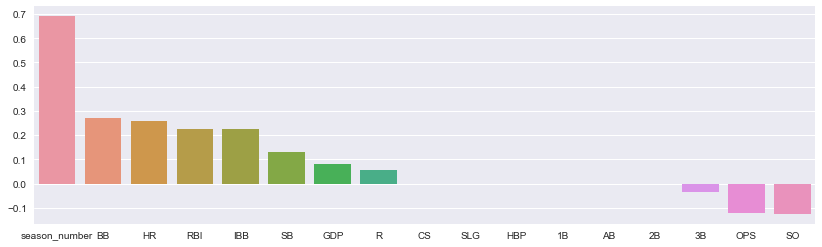

In [30]:
plt.figure(figsize=(14, 4))
lm3_feature_importance = pd.Series(lr_model3.coef_,index=X_test2.columns)
lm3_feature_importance.sort_values(ascending=False,inplace=True)
sns.barplot(lm3_feature_importance.index,lm3_feature_importance.values)
plt.show()

In [31]:
from sklearn import tree

dtrmodel = tree.DecisionTreeRegressor(min_samples_split=10, max_depth=6, min_samples_leaf=8)
dtrmodel.fit(X_train2,y_train2)
tree.export_graphviz(dtrmodel, out_file='tree.dot',feature_names = X_train2.columns)

## Lets Try Random Forest

#### Initialize the model, then fit it on the training data

In [32]:
rfmodel1 = ensemble.RandomForestRegressor(n_estimators = 1000, 
                                          min_samples_leaf= 6, 
                                          max_features=6,
                                          n_jobs=-1)
rfmodel1.fit(X_train2,y_train2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=6, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [33]:
rf1_test_pred = rfmodel1.predict(X_test2)

In [34]:
print(rfmodel1.score(X_test2,y_test2))

list(zip(X_test2.columns,rfmodel1.feature_importances_))

0.535653249482


[('season_number', 0.3817744529705937),
 ('AB', 0.032607094600439972),
 ('R', 0.066151613245874222),
 ('1B', 0.018358438944044642),
 ('2B', 0.015279989793511608),
 ('3B', 0.0077399397673544625),
 ('HR', 0.0620495701090183),
 ('RBI', 0.10352290036281195),
 ('SB', 0.016083205365355215),
 ('SLG', 0.025884684967077212),
 ('OPS', 0.058474588619991462),
 ('CS', 0.008329663888984486),
 ('BB', 0.090978986313209234),
 ('SO', 0.02145089229138877),
 ('GDP', 0.01332802789086107),
 ('HBP', 0.00926553406301007),
 ('IBB', 0.068720416806473575)]

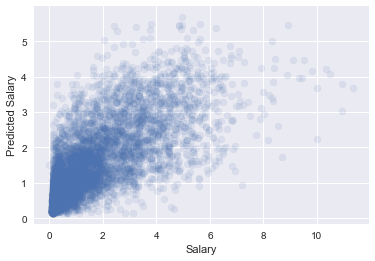

In [35]:
plt.scatter(y_test2,rf1_test_pred,alpha=0.1)
#plt.show()
plt.xlabel('Salary')
plt.ylabel('Predicted Salary')

In [36]:
print(rfmodel1.score(X_test2,y_test2))
print(np.sqrt(np.mean((rf1_test_pred - y_test2)**2)))

0.535653249482
1.10859790113


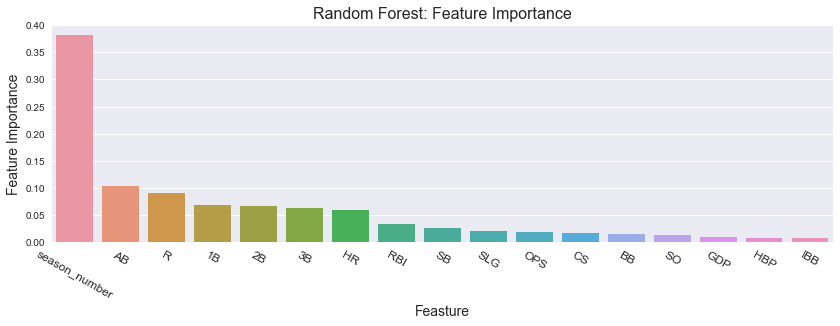

In [37]:
plt.figure(figsize=(14, 4))
rf1_feature_importance = pd.Series(rfmodel1.feature_importances_,index=X_test2.columns)
rf1_feature_importance.sort_values(ascending=False,inplace=True)
g = sns.barplot(rf1_feature_importance.index,rf1_feature_importance.values);
g.set_xticklabels(X_test2.columns, rotation=-30,size=12)
plt.ylabel('Feature Importance',size=14);
plt.xlabel('Feasture',size=14);
plt.title('Random Forest: Feature Importance',size = 16);

In [38]:
#mxr = mli.ModelXRay(rfmodel1,X_test2)

#indices = mxr.feature_dependence_plots(num_pt#s=7)

# Random Forest Optimized Using Grid Search

In [39]:
# parameters = {'min_samples_split':[5,10,15],
#               'min_samples_leaf':[3,5,10,15],
#               'n_estimators':[1000]}


parameters = {'min_samples_split':[4,6,8],
              'min_samples_leaf':[4,6,8],
              'n_estimators':[1000]}


rf_model2 = ensemble.RandomForestRegressor()
grid_search1 = GridSearchCV(rf_model2, parameters, n_jobs=-1, verbose=1)
grid_search1.fit(X_train2,y_train2)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [4, 6, 8], 'min_samples_leaf': [4, 6, 8], 'n_estimators': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [40]:
grid_search1.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=8,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [41]:
rfgs1_test_pred = grid_search1.best_estimator_.predict(X_test2)
print(grid_search1.best_estimator_.score(X_test2,y_test2))
print(np.sqrt(np.mean((rfgs1_test_pred  - y_test2)**2)))

0.541794821156
1.10124219503


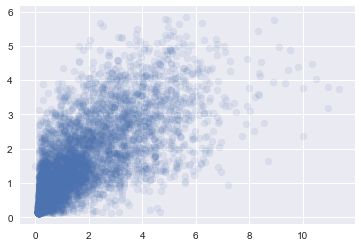

In [42]:
plt.scatter(y_test2,rfgs1_test_pred,alpha=0.1)
plt.show()

In [43]:
list(zip(X_test2.columns,grid_search1.best_estimator_.feature_importances_))

[('season_number', 0.46616051393257374),
 ('AB', 0.02417150775064917),
 ('R', 0.12063137256088716),
 ('1B', 0.012402357172752223),
 ('2B', 0.00906268026764343),
 ('3B', 0.0041821078302571148),
 ('HR', 0.028831742883926936),
 ('RBI', 0.098608145273467576),
 ('SB', 0.017597253317973641),
 ('SLG', 0.01343398016708806),
 ('OPS', 0.028475280139639805),
 ('CS', 0.0057155026933619155),
 ('BB', 0.04859426210567442),
 ('SO', 0.014406394345903477),
 ('GDP', 0.0091333173435801177),
 ('HBP', 0.0070673172833371906),
 ('IBB', 0.091526264931284435)]

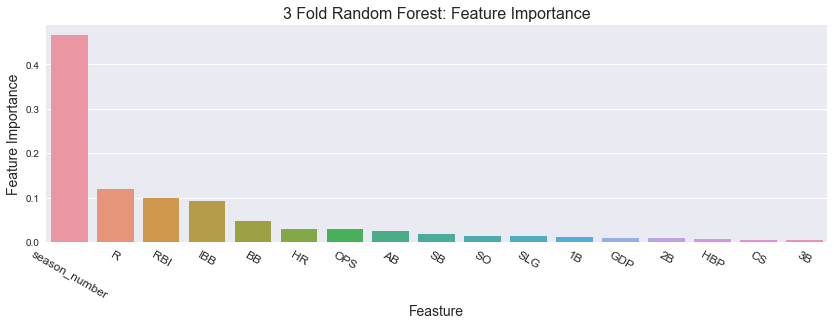

In [44]:
plt.figure(figsize=(14, 4))
gsrf1_feature_importance = pd.Series(grid_search1.best_estimator_.feature_importances_,index=X_test2.columns)
gsrf1_feature_importance.sort_values(ascending=False,inplace=True)
g = sns.barplot(gsrf1_feature_importance.index, gsrf1_feature_importance.values);
g.set_xticklabels(gsrf1_feature_importance.index, rotation=-30,size=12)
plt.ylabel('Feature Importance',size=14);
plt.xlabel('Feasture',size=14);
plt.title('3 Fold Random Forest: Feature Importance',size = 16);

In [45]:
combo_rf = copy.deepcopy(X_test2)
combo_rf['pred_salary'] = rfgs1_test_pred

combo_rf.sort_values('pred_salary',ascending=False)

,season_number,AB,R,1B,2B,3B,HR,RBI,SB,SLG,OPS,CS,BB,SO,GDP,HBP,IBB,pred_salary
11069,13.0,509.0,130.0,61.0,21.0,0.0,70.0,147.0,1.0,0.752,1.222,0.0,162.0,155.0,8.0,6.0,28.0,5.848
13739,10.0,587.0,115.0,101.0,39.0,1.0,42.0,118.0,14.0,0.596,1.011,4.0,103.0,76.0,23.0,4.0,38.0,5.790
13958,11.0,569.0,117.0,111.0,36.0,1.0,37.0,104.0,3.0,0.587,1.014,1.0,97.0,94.0,22.0,8.0,28.0,5.753
13738,9.0,568.0,124.0,93.0,45.0,1.0,47.0,135.0,16.0,0.658,1.101,4.0,115.0,64.0,23.0,9.0,44.0,5.751
15956,13.0,577.0,146.0,86.0,34.0,5.0,64.0,160.0,0.0,0.737,1.174,2.0,116.0,153.0,6.0,6.0,37.0,5.678
6347,12.0,609.0,128.0,98.0,36.0,7.0,57.0,142.0,1.0,0.688,1.117,1.0,100.0,83.0,14.0,14.0,24.0,5.678
11070,14.0,521.0,118.0,58.0,21.0,1.0,65.0,147.0,0.0,0.697,1.120,0.0,133.0,141.0,12.0,2.0,21.0,5.628
12555,10.0,558.0,115.0,75.0,29.0,2.0,54.0,137.0,1.0,0.636,1.049,0.0,119.0,117.0,12.0,4.0,23.0,5.587
13737,8.0,524.0,100.0,106.0,44.0,0.0,37.0,116.0,7.0,0.653,1.114,3.0,104.0,54.0,16.0,5.0,34.0,5.548
6034,8.0,497.0,95.0,68.0,37.0,5.0,38.0,103.0,15.0,0.622,1.072,6.0,135.0,74.0,10.0,7.0,24.0,5.497


# Boosted Trees

In [46]:
parameters = {'subsample':np.arange(.6,.8,.1),
              'max_depth':[3,5,10],
              'learning_rate':[0.01],
              'n_estimators':[1000]}

model = ensemble.GradientBoostingRegressor()
grid_search2 = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)
grid_search2.fit(X_train2,y_train2)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   37.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': array([ 0.6,  0.7,  0.8]), 'max_depth': [3, 5, 10], 'learning_rate': [0.01], 'n_estimators': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [47]:
list(zip(X_test2.columns, grid_search2.best_estimator_.feature_importances_))

[('season_number', 0.18800953969830306),
 ('AB', 0.065665136411092576),
 ('R', 0.050290509816033356),
 ('1B', 0.048624104506551996),
 ('2B', 0.029933204330043428),
 ('3B', 0.015877161055478154),
 ('HR', 0.05853793310933373),
 ('RBI', 0.06951374031582401),
 ('SB', 0.045429302522383724),
 ('SLG', 0.063479745233766052),
 ('OPS', 0.069359040519267015),
 ('CS', 0.024520851802741203),
 ('BB', 0.06594822250392697),
 ('SO', 0.059232795169496297),
 ('GDP', 0.038755247277494728),
 ('HBP', 0.032855683045192999),
 ('IBB', 0.073967782683070901)]

In [48]:
grbst_test_pred = grid_search2.best_estimator_.predict(X_test2)
print(grid_search2.best_estimator_.score(X_test2,y_test2))
print(np.sqrt(np.mean((grbst_test_pred  - y_test2)**2)))

0.536889810661
1.10712081209


In [49]:
combo_grbst = X_test2
combo_grbst['pred_salary'] = grbst_test_pred 

combo_grbst.sort_values('pred_salary',ascending=False)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,season_number,AB,R,1B,2B,3B,HR,RBI,SB,SLG,OPS,CS,BB,SO,GDP,HBP,IBB,pred_salary
13739,10.0,587.0,115.0,101.0,39.0,1.0,42.0,118.0,14.0,0.596,1.011,4.0,103.0,76.0,23.0,4.0,38.0,6.459
13738,9.0,568.0,124.0,93.0,45.0,1.0,47.0,135.0,16.0,0.658,1.101,4.0,115.0,64.0,23.0,9.0,44.0,6.415
13958,11.0,569.0,117.0,111.0,36.0,1.0,37.0,104.0,3.0,0.587,1.014,1.0,97.0,94.0,22.0,8.0,28.0,6.397
6564,10.0,582.0,110.0,92.0,31.0,1.0,42.0,114.0,8.0,0.558,0.944,5.0,93.0,112.0,26.0,5.0,22.0,6.283
6347,12.0,609.0,128.0,98.0,36.0,7.0,57.0,142.0,1.0,0.688,1.117,1.0,100.0,83.0,14.0,14.0,24.0,6.016
6253,8.0,630.0,108.0,138.0,45.0,3.0,27.0,117.0,1.0,0.548,0.957,0.0,74.0,119.0,28.0,6.0,20.0,5.797
13737,8.0,524.0,100.0,106.0,44.0,0.0,37.0,116.0,7.0,0.653,1.114,3.0,104.0,54.0,16.0,5.0,34.0,5.792
8743,10.0,548.0,90.0,117.0,35.0,1.0,26.0,100.0,8.0,0.536,0.972,2.0,107.0,89.0,18.0,2.0,23.0,5.689
12757,11.0,626.0,110.0,100.0,40.0,2.0,39.0,142.0,8.0,0.546,0.927,0.0,95.0,96.0,9.0,3.0,12.0,5.652
10701,13.0,561.0,87.0,123.0,33.0,0.0,32.0,103.0,3.0,0.565,0.974,2.0,70.0,42.0,17.0,4.0,28.0,5.637


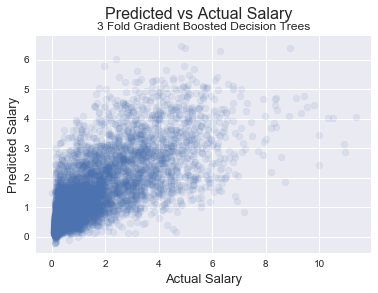

In [50]:
plt.scatter(y_test2,grbst_test_pred,alpha=0.1)
plt.ylabel('Predicted Salary',size=13);
plt.xlabel('Actual Salary',size=13);
plt.suptitle('Predicted vs Actual Salary',size = 16);
plt.title('3 Fold Gradient Boosted Decision Trees',size = 12);

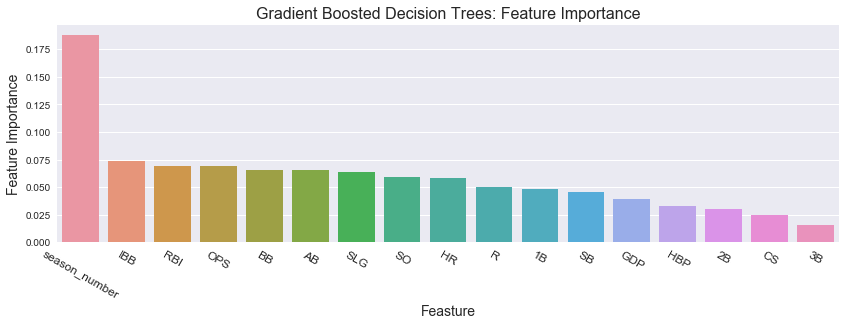

In [51]:
plt.figure(figsize=(14, 4))
gsbt1_feature_importance = pd.Series(grid_search2.best_estimator_.feature_importances_, index=X_test2.columns[:-1])
gsbt1_feature_importance.sort_values(ascending=False,inplace=True)
g = sns.barplot(gsbt1_feature_importance.index, gsbt1_feature_importance);
g.set_xticklabels(gsbt1_feature_importance.index, rotation=-30,size=12)
plt.ylabel('Feature Importance',size=14);
plt.xlabel('Feasture',size=14);
plt.title('Gradient Boosted Decision Trees: Feature Importance',size = 16);

## Minor League Data to Predict Max Salary

Position data not available for minor leaguers

In [52]:
# keep_cols = ['AB', 'R', '1B', '2B', '3B', 'HR', 'RBI', 'SB', \
#              'CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','normalized_salary']

keep_cols = ['player_id','AB', 'R', 'BA', 'H','SLG', 'OPS', 'HR','HR_rate', 'RBI', 'SB', \
             'BB_rate', 'SO_rate', 'IBB', 'normalized_salary']


# keep_cols = ['AB','SLG', 'OPS', 'SB', \
#              'BB', 'SO', 'IBB', 'normalized_salary']

# keep_cols = ['AB','SLG', 'OPS', 'SB', \
#              'BB_rate', 'SO_rate', 'IBB', 'normalized_salary']

# keep_cols = ['player_id', 'AB', 'R','1B', '2B', '3B', 'HR', 'RBI', 'SB', \
#              'SLG', 'OPS','CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','normalized_salary']

# keep_cols = ['season_number', 'AB', 'R', 'H','SLG','OPS', 'HR', 'RBI', 'SB', \
#        'CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','normalized_salary']

# Try and then try adding postions


# Filtering out people making close to the minimum
# majors_df_reduced2 = majors_df[(majors_df['Salary'] >= 1.5*majors_df['min_salary']) 
#               & (majors_df['AB']>200)][keep_cols].dropna(axis=0,how = 'any')
minors_career_reduced = minors_career_df[keep_cols].dropna(axis=0,how = 'any')
minors_career_reduced = minors_career_reduced.loc[(minors_career_df['AB']>200)]

# majors_df_reduced2 = majors_df.loc[(majors_df['AB']>300) 
#                                              & (majors_df['season_number']> 6)][keep_cols].dropna(axis=0,how = 'any')


X_all3 = minors_career_reduced.iloc[:,minors_career_reduced.columns != 'normalized_salary']
y_all3 = minors_career_reduced['normalized_salary']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_all3, y_all3, test_size=0.3)
X_train3.iloc[:,1:]

,AB,R,BA,H,SLG,OPS,HR,HR_rate,RBI,SB,BB_rate,SO_rate,IBB
579,2449.0,287.0,0.261,638.0,0.376,0.685,35.0,0.013,267.0,56.0,0.058,0.283,6.0
958,2303.0,334.0,0.274,631.0,0.453,0.790,71.0,0.028,346.0,34.0,0.081,0.225,5.0
910,989.0,133.0,0.305,302.0,0.441,0.831,26.0,0.023,155.0,11.0,0.118,0.099,0.0
169,2332.0,303.0,0.260,606.0,0.410,0.726,60.0,0.023,314.0,26.0,0.074,0.173,16.0
2037,2485.0,419.0,0.280,695.0,0.470,0.863,94.0,0.031,480.0,10.0,0.153,0.188,27.0
1842,3661.0,559.0,0.273,998.0,0.442,0.807,122.0,0.029,524.0,69.0,0.122,0.183,15.0
450,5002.0,855.0,0.259,1298.0,0.465,0.810,194.0,0.034,821.0,119.0,0.107,0.212,36.0
1992,2054.0,262.0,0.262,538.0,0.339,0.655,17.0,0.008,197.0,64.0,0.066,0.117,12.0
273,3394.0,575.0,0.290,983.0,0.448,0.813,100.0,0.026,494.0,162.0,0.092,0.170,8.0
264,1015.0,140.0,0.290,294.0,0.389,0.745,11.0,0.010,108.0,31.0,0.090,0.134,0.0


LassoCV

In [53]:
std = StandardScaler()
#std.fit(X_train.values.astype(float))
std.fit(X_train3.iloc[:,1:])

X_tr3 = std.transform(X_train3.iloc[:,1:])
X_te3 = std.transform(X_test3.iloc[:,1:])


# Can use the same slicing of the data as before
lr_model4 = LassoCV(alphas = alphavec, cv=5)
lr_model4.fit(X_tr3,y_train3)
lr_model4.alpha_

list(zip(X_test3.columns[1:],lr_model4.coef_))

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[('AB', 0.41279972736920717),
 ('R', -0.59899763008849016),
 ('BA', 0.85763519002327182),
 ('H', -0.78487765051485081),
 ('SLG', 0.94097094514881419),
 ('OPS', -1.3604614044251693),
 ('HR', 0.14685844584609348),
 ('HR_rate', 0.4178603651621931),
 ('RBI', -0.22522785627217923),
 ('SB', 0.29351346735720807),
 ('BB_rate', 0.42670857481971125),
 ('SO_rate', 0.0030482336975650105),
 ('IBB', 0.17599279310885743)]

In [54]:
lm_pred4 = lr_model4.predict(X_te3)
lr_model4.score(X_te3,y_test3)

0.38895164876504862

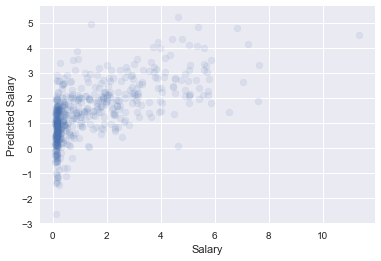

In [55]:
plt.scatter(y_test3,lm_pred4,alpha=0.1)
plt.xlabel('Salary')
plt.ylabel('Predicted Salary')

Random Forest

In [56]:
rfmodel3 = ensemble.RandomForestRegressor(n_estimators = 1000, 
                                          min_samples_leaf= 6, 
                                          max_features=5,
                                          n_jobs=-1)
rfmodel3.fit(X_train3.iloc[:,1:],y_train3)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=6, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [57]:
rf3_test_pred = rfmodel3.predict(X_test3.iloc[:,1:])
print(rfmodel3.score(X_test3.iloc[:,1:],y_test3))
print(np.sqrt(np.mean((rf3_test_pred - y_test3)**2)))
list(zip(X_test3.columns[1:],rfmodel3.feature_importances_))

0.42362066451
1.27596345504


[('AB', 0.26779161407682173),
 ('R', 0.091435990785590018),
 ('BA', 0.067906020799256367),
 ('H', 0.16126744976123353),
 ('SLG', 0.079275576180873136),
 ('OPS', 0.075617609067319722),
 ('HR', 0.026496174239944114),
 ('HR_rate', 0.046363193155479702),
 ('RBI', 0.05015103839134015),
 ('SB', 0.037388824303827339),
 ('BB_rate', 0.030820949932809906),
 ('SO_rate', 0.027824282870417619),
 ('IBB', 0.037661276435087085)]

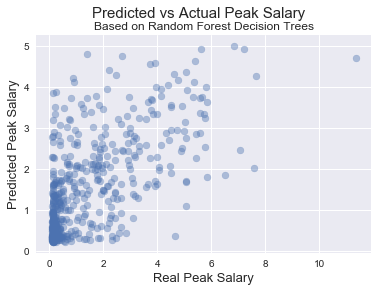

In [58]:
plt.scatter(y_test3,rf3_test_pred,alpha =0.4)

plt.xlabel('Real Peak Salary',size = 13)
plt.ylabel('Predicted Peak Salary',size = 13)
plt.suptitle('Predicted vs Actual Peak Salary',size =15)
plt.title('Based on Random Forest Decision Trees')
plt.show()

In [59]:
X_test3.columns[:-1]

Index(['player_id', 'AB', 'R', 'BA', 'H', 'SLG', 'OPS', 'HR', 'HR_rate', 'RBI',
       'SB', 'BB_rate', 'SO_rate'],
      dtype='object')

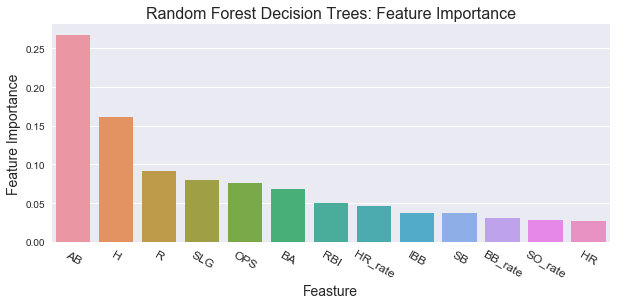

In [60]:
plt.figure(figsize=(10, 4))
rfmodel3_importances = pd.Series(rfmodel3.feature_importances_, index=X_test3.columns[1:])
rfmodel3_importances.sort_values(ascending=False,inplace=True)
g = sns.barplot(rfmodel3_importances.index, rfmodel3_importances);
g.set_xticklabels(rfmodel3_importances.index, rotation=-30,size=12)
plt.ylabel('Feature Importance',size=14);
plt.xlabel('Feasture',size=14);
plt.title('Random Forest Decision Trees: Feature Importance',size = 16);

In [62]:
combo = copy.deepcopy(X_test3)
combo['salary_measured'] = y_test3
combo['salary_predicted'] = rf3_test_pred
combo.sort_values('salary_predicted',ascending = False).head(20)

,player_id,AB,R,BA,H,SLG,OPS,HR,HR_rate,RBI,SB,BB_rate,SO_rate,IBB,salary_measured,salary_predicted
848,griffke02,465.0,103.0,0.318,148.0,0.572,0.997,27.0,0.049,92.0,49.0,0.150,0.169,8.0,6.842,5.009
174,berkmla01,1062.0,197.0,0.308,327.0,0.547,0.973,58.0,0.045,221.0,19.0,0.166,0.168,19.0,5.611,4.937
2118,teixema01,340.0,63.0,0.306,104.0,0.565,0.970,19.0,0.048,70.0,5.0,0.125,0.158,2.0,7.222,4.923
1218,leetr01,509.0,111.0,0.328,167.0,0.605,1.028,32.0,0.053,115.0,8.0,0.137,0.155,8.0,1.410,4.821
2080,stubbfr01,1357.0,249.0,0.273,371.0,0.538,0.912,84.0,0.052,290.0,39.0,0.139,0.192,20.0,2.699,4.759
1846,rodrial01,717.0,126.0,0.321,230.0,0.594,0.979,42.0,0.052,148.0,22.0,0.090,0.184,6.0,11.352,4.725
536,dawsoan01,693.0,130.0,0.339,235.0,0.605,1.001,41.0,0.053,123.0,30.0,0.075,0.171,0.0,5.384,4.649
2357,zimmery01,390.0,64.0,0.323,126.0,0.533,0.895,15.0,0.036,57.0,1.0,0.055,0.153,4.0,3.914,4.602
2251,wallati01,807.0,159.0,0.300,242.0,0.591,0.961,55.0,0.060,186.0,1.0,0.098,0.171,0.0,3.714,4.575
1810,reynoma01,1324.0,254.0,0.282,374.0,0.526,0.888,73.0,0.048,264.0,12.0,0.096,0.232,6.0,2.213,4.421


In [63]:
# mxr = mli.ModelXRay(rfmodel3,X_test3.iloc[:,1:],resolution=50)

# indices = mxr.feature_dependence_plots(num_pts=10)
# plt.show()

# indices

In [64]:
#X_test3.iloc[indices]

parameters = {'subsample':np.arange(.6,.8,.1),
              'max_depth':[3,4,5],
              'learning_rate':[0.01],
              'n_estimators':[1000]}

gbmodel3 = ensemble.GradientBoostingRegressor()
grid_search3 = GridSearchCV(gbmodel3, parameters, n_jobs=-1, verbose=1)
grid_search3.fit(X_train3.iloc[:,1:],y_train3)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   13.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': array([ 0.6,  0.7,  0.8]), 'max_depth': [3, 4, 5], 'learning_rate': [0.01], 'n_estimators': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [65]:
grid_search3.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None,
             subsample=0.59999999999999998, verbose=0, warm_start=False)

In [66]:
grbst_test_pred3 = grid_search3.best_estimator_.predict(X_test3.iloc[:,1:])
print(grid_search3.best_estimator_.score(X_test3.iloc[:,1:],y_test3))
print(np.sqrt(np.mean((grbst_test_pred3  - y_test3)**2)))

0.426732993067
1.27251382325


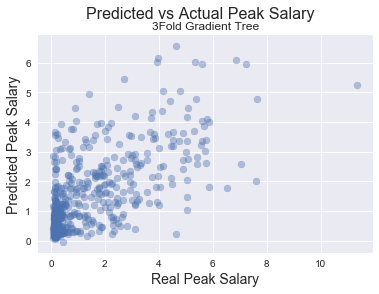

In [67]:
plt.scatter(y_test3,grbst_test_pred3,alpha = .4)

plt.xlabel('Real Peak Salary',size = 14)
plt.ylabel('Predicted Peak Salary',size = 14)
plt.suptitle('Predicted vs Actual Peak Salary',size =16)
plt.title('3Fold Gradient Tree')
plt.show()